In [10]:
import sys
sys.path.append('C:/projekty/piunet/Code/piunet')

import os
import numpy as np
import torch
import torch.nn.functional as func
import torch.utils.data
from PIL import Image
from tqdm import tqdm

from config import Config, ConfigNIR, ConfigRED
from dataset import ProbaVDatasetVal
from losses import custom_metric_model_shifts_from_cpsnr
from metrics.models import load_lpips, Models
from model import PIUNET
from torchvision.transforms.functional import to_pil_image
from IPython.display import display

In [11]:
test_loader = torch.utils.data.DataLoader(ProbaVDatasetVal(ConfigRED()), batch_size=1, shuffle=False, drop_last=False)
config = Config()
model = PIUNET(config, None)
problems = model.load_state_dict(torch.load("C:/projekty/piunet/Code/piunet/red_model_checkpoint.pt"))
model.cuda()

PIUNET(
  (conv_in): Conv3d(1, 42, kernel_size=[1, 3, 3], stride=(1, 1, 1), padding=[0, 1, 1])
  (tran_in): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=42, out_features=42, bias=True)
  )
  (norm00): BatchNorm3d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm0): BatchNorm3d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): ModuleList(
    (0): TEFA(
      (conv0): Conv3d(42, 42, kernel_size=[1, 3, 3], stride=(1, 1, 1), padding=[0, 1, 1])
      (norm00): BatchNorm3d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tran0): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=42, out_features=42, bias=True)
      )
      (norm0): BatchNorm3d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv3d(42, 42, kernel_size=[1, 3, 3], stride=(1, 1, 1), padding=[0, 1, 1])
      (tran1): MultiheadAttention(
        (out_proj): _LinearWithBias(in_featu

HR


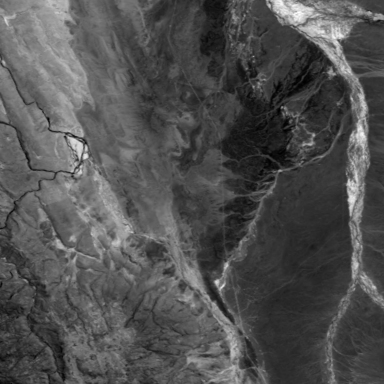

LR


C:\projekty\piunet\venv\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


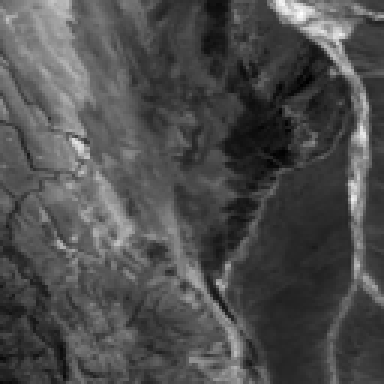

SR on torch.Size([1, 9, 128, 128])


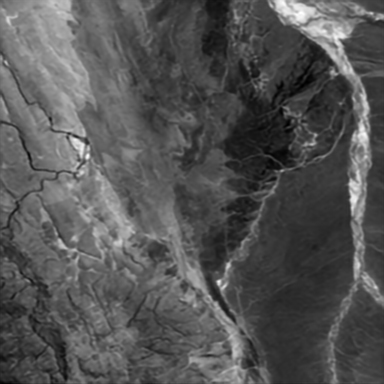

SR on torch.Size([1, 7, 128, 128])


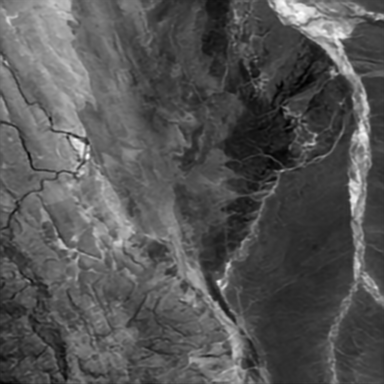

SR on torch.Size([1, 5, 128, 128])


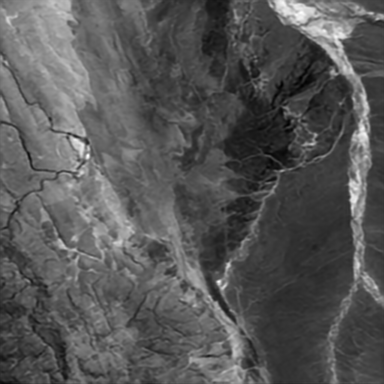

SR on torch.Size([1, 3, 128, 128])


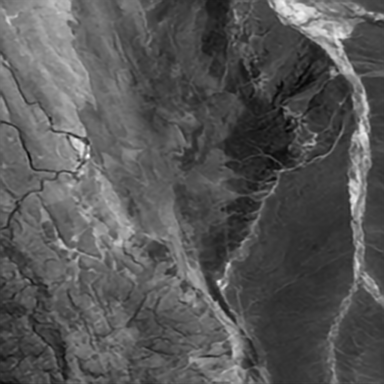

SR on torch.Size([1, 1, 128, 128])


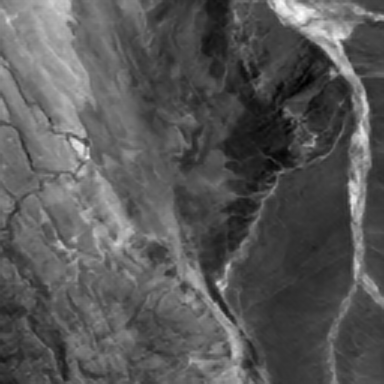

In [12]:
def normalize(tnsr):
    mu_sr = tnsr.squeeze(0)
    min_val = mu_sr.min()
    max_val = mu_sr.max()
    return (mu_sr - min_val) / (max_val - min_val)

def execute_on_subset(test_lr, start_idx, model):
    test_lr_ = test_lr[:, start_idx:, :, :]
    print(f"SR on {test_lr_.shape}")
    test_lr_ = torch.Tensor(test_lr_).to(config.device)
    mu_sr, sigma_sr = model(test_lr_)
    display(to_pil_image(normalize(mu_sr)))

model.eval()
with torch.no_grad():
    test_lr, test_hr, _ = list(test_loader)[100]
    print("HR")
    display(to_pil_image(normalize(test_hr)))
    
    print("LR")
    display(to_pil_image(normalize(test_lr[:, 1, :, :])).resize((test_hr.shape[-2], test_hr.shape[-1]), Image.NEAREST))
    
    execute_on_subset(test_lr, 0, model)
    execute_on_subset(test_lr, 2, model)
    execute_on_subset(test_lr, 4, model)
    execute_on_subset(test_lr, 6, model)
    execute_on_subset(test_lr, 8, model)